### 09_18_2025_37C (High contrast) 

Found 18 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_good_contrast/zip_37C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_good_contrast/zip_37C_40x (1).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_good_contrast/syg1_37C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_good_contrast/syg1_37C_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_good_contrast/syg1_37C_40x (1).jpg']
ku80_37C_40x (1).jpg -> N=98  germinated=22  (22.4%)  mask=otsu_invert  seed_min_dist=14  overlay=ku80_37C_40x (1)_overlay.png
ku80_37C_40x (2).jpg -> N=61  g

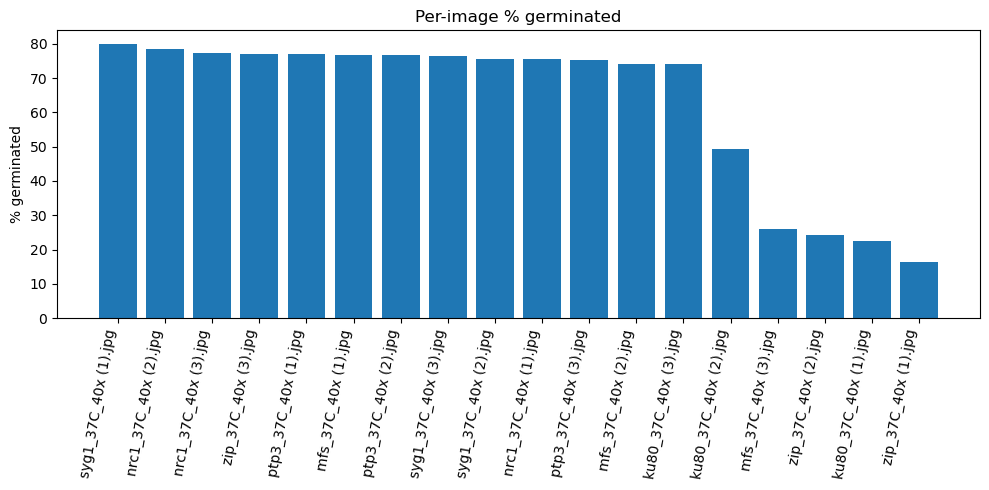

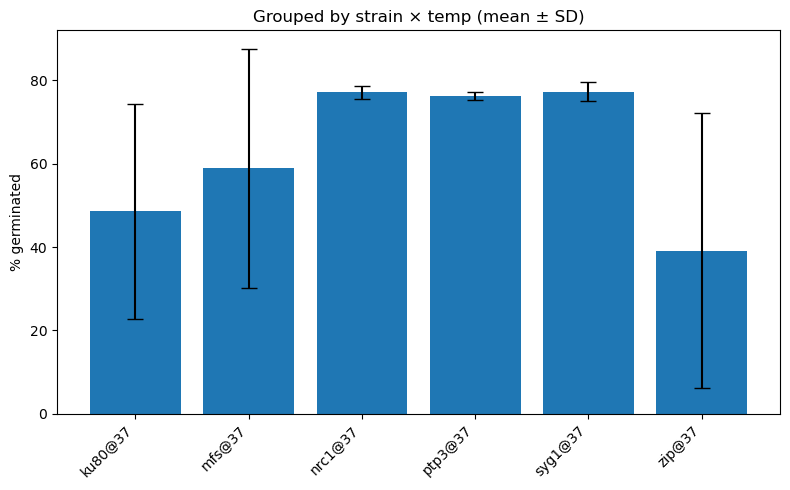

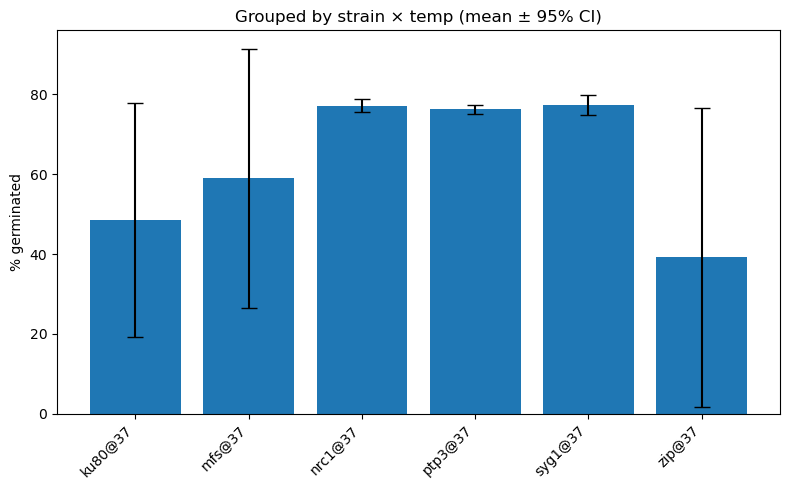

In [1]:
# === Batch Fungal Germination Counter (40×, robust v3) =======================
# Germinated if germ tube length ≥ 0.8 × that spore’s diameter (in µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_good_contrast"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# 40× tuned thresholds (patched to keep spore–tube connections)
MIN_AREA = 200           # px^2 (raise if fragments remain: 170–200)
MAX_AREA = 1800          # px^2 (lower if big blobs slip through)
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 0       # <-- no opening; don't break thin tubes
HOLE_AREA = 96
WATERSHED_SPLIT = True

# Adaptive Sauvola (gentler) for 40×
SAUVOLA_WINDOW = 41
SAUVOLA_K = 0.12

# Scale & germination rule
UM_PER_PX = 0.22         # <-- set from your 100 µm scale bar
MIN_TUBE_MULTIPLE = 1.2  # tube must be ≥ 0.8× that spore’s diameter
BORDERLINE_UM = 1.0

# debris/shape guards (looser to keep thin hyphae)
MIN_SOLIDITY = 0.80      # kept for reference, not used directly now
MIN_CIRCULARITY = 0.55   # kept for reference, not used directly now
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)  # replicate like " (3).jpg"
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)

    # ---- robust masking: try multiple methods, pick best ----
    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)           # solid spores (no ring fragments)
        # no opening; DO a slightly stronger closing to keep spore–tube bridges
        bw = morphology.binary_closing(bw, morphology.disk(2))
        return bw

    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)
        frac_big = (max(areas)/max(1, int(mask.sum()))) if areas else 1.0
        return (n_ok, -frac_big)  # higher is better

    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bwN = cleanup(blur > thN)
    bwI = cleanup(blur_inv > thI)

    otsu = filters.threshold_otsu(blur_inv)
    yen  = filters.threshold_yen(blur_inv)
    tri  = filters.threshold_triangle(blur_inv)
    bwO = cleanup(blur_inv > otsu)
    bwY = cleanup(blur_inv > yen)
    bwT = cleanup(blur_inv > tri)

    candidates = [("sauv_normal", bwN), ("sauv_invert", bwI),
                  ("otsu_invert", bwO), ("yen_invert", bwY), ("tri_invert", bwT)]
    name, bw, _ = max(((nm, m, score_mask(m)) for nm, m in candidates), key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (denser split) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    # denser seeding: 0.30 × median spore diameter, clipped to 10–16 px
    #min_dist = int(np.clip(0.30 * med_eq_px, 10, 16))
    #min_dist = int(np.clip(0.35 * med_eq_px, 12, 18))
    min_dist = int(np.clip(0.40 * med_eq_px, 14, 20))

    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: if under-segmented (giant component), try h-maxima split
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.45 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ 0.8× diameter) ----
    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))

        # Looser debris guard: drop only wisps; keep thin hyphae
        if (solidity < 0.45 and circularity < 0.25):
            continue

        equiv_px = p.equivalent_diameter

        # --- measure skeleton on a 1-px dilated region to keep continuity
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(1))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)
        #cutoff_um = MIN_TUBE_MULTIPLE * equiv_um
        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, 5.0)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity",
            "is_germinated","margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # PLOTS
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
        plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± SD)")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("% germinated")
        plt.title("Grouped by strain × temp (mean ± 95% CI)")
        plt.tight_layout()
        plt.show()


### 09_09_2025_37C (low contrast)

Found 22 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/zip_37C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/zip_37C_40x (1).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/syg1_37C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/syg1_37C_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/ptp3_37C_40x (3).jpg']
ku80_37C_40x (1).jpg -> N=52  germinated=10  (19.2%)  mask=otsu_invert  seed_min_dist=15  overlay=ku80_37C_40x (1)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/ku80_37C_40x (2)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))


ku80_37C_40x (2).jpg -> N=24  germinated=2  (8.3%)  mask=otsu_invert  seed_min_dist=15  overlay=ku80_37C_40x (2)_overlay.png
ku80_37C_40x (3).jpg -> N=40  germinated=0  (0.0%)  mask=feat_tri  seed_min_dist=15  overlay=ku80_37C_40x (3)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/mfs_37C_40x (1)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/mfs_37C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


mfs_37C_40x (1).jpg -> N=26  germinated=0  (0.0%)  mask=otsu_invert  seed_min_dist=15  overlay=mfs_37C_40x (1)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/mfs_37C_40x (2)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/mfs_37C_40x (2)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


mfs_37C_40x (2).jpg -> N=19  germinated=3  (15.8%)  mask=otsu_invert  seed_min_dist=15  overlay=mfs_37C_40x (2)_overlay.png
mfs_37C_40x (3).jpg -> N=43  germinated=8  (18.6%)  mask=otsu_invert  seed_min_dist=16  overlay=mfs_37C_40x (3)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/nrc1_37C_40x (1)_mask_yen_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/nrc1_37C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


nrc1_37C_40x (1).jpg -> N=31  germinated=3  (9.7%)  mask=yen_invert  seed_min_dist=16  overlay=nrc1_37C_40x (1)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/nrc1_37C_40x (2)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


nrc1_37C_40x (2).jpg -> N=27  germinated=0  (0.0%)  mask=feat_otsu  seed_min_dist=15  overlay=nrc1_37C_40x (2)_overlay.png
nrc1_37C_40x (3).jpg -> N=34  germinated=6  (17.6%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_37C_40x (3)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/ptp3_37C_40x (1)_mask_yen_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/ptp3_37C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ptp3_37C_40x (1).jpg -> N=16  germinated=2  (12.5%)  mask=yen_invert  seed_min_dist=15  overlay=ptp3_37C_40x (1)_overlay.png
ptp3_37C_40x (2).jpg -> N=41  germinated=0  (0.0%)  mask=feat_tri  seed_min_dist=15  overlay=ptp3_37C_40x (2)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/ptp3_37C_40x (3)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/ptp3_37C_40x (3)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ptp3_37C_40x (3).jpg -> N=23  germinated=3  (13.0%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_37C_40x (3)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/syg1_37C_40x (1)_mask_feat_yen.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/syg1_37C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


syg1_37C_40x (1).jpg -> N=15  germinated=0  (0.0%)  mask=feat_yen  seed_min_dist=16  overlay=syg1_37C_40x (1)_overlay.png


/tmp/ipykernel_2664847/3468396895.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/syg1_37C_40x (2)_mask_feat_otsu.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/3468396895.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast/syg1_37C_40x (2)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


syg1_37C_40x (2).jpg -> N=17  germinated=0  (0.0%)  mask=feat_otsu  seed_min_dist=15  overlay=syg1_37C_40x (2)_overlay.png
syg1_37C_40x (3).jpg -> N=199  germinated=72  (36.2%)  mask=otsu_invert  seed_min_dist=15  overlay=syg1_37C_40x (3)_overlay.png
zip_37C_40x (1).jpg -> N=65  germinated=12  (18.5%)  mask=otsu_invert  seed_min_dist=16  overlay=zip_37C_40x (1)_overlay.png
zip_37C_40x (2).jpg -> N=56  germinated=7  (12.5%)  mask=otsu_invert  seed_min_dist=15  overlay=zip_37C_40x (2)_overlay.png
zip_37C_40x (2)_mask_otsu_invert.png -> N=57  germinated=0  (0.0%)  mask=feat_yen  seed_min_dist=15  overlay=zip_37C_40x (2)_mask_otsu_invert_overlay.png
zip_37C_40x (2)_overlay.png -> N=117  germinated=10  (8.5%)  mask=tri_invert  seed_min_dist=15  overlay=zip_37C_40x (2)_overlay_overlay.png
zip_37C_40x (3).jpg -> N=33  germinated=1  (3.0%)  mask=yen_invert  seed_min_dist=15  overlay=zip_37C_40x (3)_overlay.png
zip_37C_40x (3)_mask_yen_invert.png -> N=32  germinated=2  (6.2%)  mask=feat_yen  se

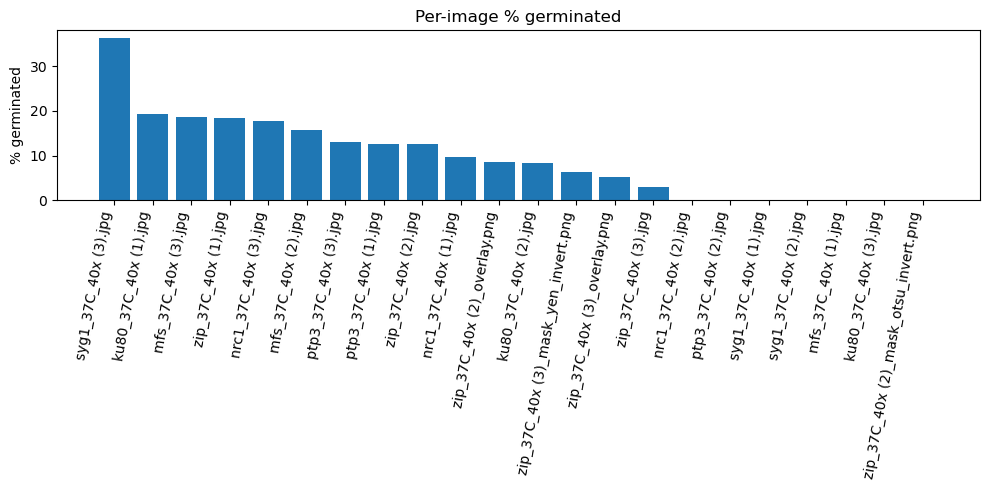

In [3]:
# === Batch Fungal Germination Counter (40×, hybrid + robust v2) ==============
# Germinated if germ tube length ≥ max(1.3× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/37C/09_18_2025_37C_low_contrast"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Size gates & seeding tuned for consistency
MIN_AREA = 220           # px^2 (raise to 240 if tiny specks persist)
MAX_AREA = 1800          # px^2
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96

# Germination rule
UM_PER_PX = 0.22         # <-- set from your scale bar
MIN_TUBE_MULTIPLE = 1.3  # relative minimum (was 1.5)
ABS_TUBE_MIN_UM = 5.0    # absolute minimum (µm)
BORDERLINE_UM = 1.0

# Skeleton continuity (NEW: more forgiving)
SKELETON_DILATE = 2      # was 1

# Feature/contrast gating
TOPHAT_RADIUS = 15       # px (~3–4 µm @ 40×)
FEAT_MIN = 0.035         # min mean feature intensity inside a component (0–1)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & mild enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = filters.gaussian(gray, sigma=GAUSSIAN_SIGMA)

    # ---- background suppression via top-hat (feature image) ----
    disk = morphology.disk(TOPHAT_RADIUS)
    wh = morphology.white_tophat(g, footprint=disk)
    bh = morphology.white_tophat(1.0 - g, footprint=disk)
    feat = np.maximum(wh, bh)
    feat = feat / (feat.max() + 1e-8)

    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)
        bw = morphology.binary_closing(bw, morphology.disk(3))  # bridge tiny gaps
        return bw

    def safe_thresh(fn, arr):
        try:
            return fn(arr)
        except ValueError:
            return 0.0

    # --- candidate masks on FEATURE image ---
    th_of = safe_thresh(filters.threshold_otsu,     feat)
    th_yf = safe_thresh(filters.threshold_yen,      feat)
    th_tf = safe_thresh(filters.threshold_triangle, feat)
    bw_feat_otsu = cleanup(feat > th_of)
    bw_feat_yen  = cleanup(feat > th_yf)
    bw_feat_tri  = cleanup(feat > th_tf)

    # --- candidate masks on ORIGINAL (for clean fields) ---
    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    SAUVOLA_WINDOW, SAUVOLA_K = 41, 0.12
    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw_sauv_n = cleanup(blur > thN)
    bw_sauv_i = cleanup(blur_inv > thI)

    to = safe_thresh(filters.threshold_otsu,     blur_inv)
    ty = safe_thresh(filters.threshold_yen,      blur_inv)
    tt = safe_thresh(filters.threshold_triangle, blur_inv)
    bw_otsu_i = cleanup(blur_inv > to)
    bw_yen_i  = cleanup(blur_inv > ty)
    bw_tri_i  = cleanup(blur_inv > tt)

    # --- scoring: plausible count, low confetti, not over-merged,
    #              prefer masks with strong feature signal, avoid ultra-sparse ---
    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        if not areas:
            return (-1e9,)  # worst score
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)

        # tiny specks fraction (confetti)
        small = sum(a for a in areas if a < MIN_AREA)
        confetti = small / max(1, int(mask.sum()))

        # over-merge indicator
        frac_big = max(areas) / max(1, int(mask.sum()))

        # target range for n_ok (tuned for 40× fields)
        lo, hi = 30, 200
        band_pen = 0.0
        if n_ok < lo:
            band_pen = - (lo - n_ok) * 0.75
        elif n_ok > hi:
            band_pen = - (n_ok - hi) * 0.10

        # NEW: reward masks whose pixels have strong feature response
        feat_mean = float(feat[mask].mean()) if mask.any() else 0.0
        feat_bonus = 20.0 * feat_mean

        # NEW: penalize ultra-sparse masks (low-contrast globals)
        fill = mask.mean()  # fraction of image marked
        sparse_pen = 0.0 if fill >= 0.005 else -50.0

        return (n_ok + band_pen) - 150.0*confetti - 5.0*frac_big + feat_bonus + sparse_pen

    candidates = [
        ("feat_otsu", bw_feat_otsu),
        ("feat_yen",  bw_feat_yen),
        ("feat_tri",  bw_feat_tri),
        ("sauv_normal", bw_sauv_n),
        ("sauv_invert", bw_sauv_i),
        ("otsu_invert", bw_otsu_i),
        ("yen_invert",  bw_yen_i),
        ("tri_invert",  bw_tri_i),
    ]
    scored = [(nm, m, score_mask(m)) for nm, m in candidates]
    name, bw, _ = max(scored, key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))
    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: stronger peak suppression if one giant blob
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ max(1.3×D, 5 µm)) with contrast gate ----
    props = measure.regionprops(labels, intensity_image=feat)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        mean_feat = float(p.mean_intensity) if hasattr(p, "mean_intensity") else 0.0
        if mean_feat < FEAT_MIN:
            continue  # drop flat background blobs

        # drop only obvious wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        # measure skeleton on a dilated region (NEW: SKELETON_DILATE=2)
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(SKELETON_DILATE))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_px = p.equivalent_diameter
        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "mean_feat": mean_feat,
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","mean_feat","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity","is_germinated",
            "margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # Optional quick plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()


### 09_18_2025_45C (low contrast) 

Found 18 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/zip_45C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/zip_45C_40x (1).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/syg1_45C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/zip_45C_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/syg1_45C_40x (2).jpg']


/tmp/ipykernel_2664847/2408431695.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/ku80_45C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ku80_45C_40x (1).jpg -> N=70  germinated=29  (41.4%)  mask=otsu_invert  seed_min_dist=15  overlay=ku80_45C_40x (1)_overlay.png


/tmp/ipykernel_2664847/2408431695.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/ku80_45C_40x (2)_mask_feat_otsu.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/2408431695.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/ku80_45C_40x (2)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ku80_45C_40x (2).jpg -> N=10  germinated=0  (0.0%)  mask=feat_otsu  seed_min_dist=15  overlay=ku80_45C_40x (2)_overlay.png
ku80_45C_40x (3).jpg -> N=50  germinated=13  (26.0%)  mask=yen_invert  seed_min_dist=15  overlay=ku80_45C_40x (3)_overlay.png
mfs_45C_40x (1).jpg -> N=73  germinated=5  (6.8%)  mask=otsu_invert  seed_min_dist=15  overlay=mfs_45C_40x (1)_overlay.png
mfs_45C_40x (2).jpg -> N=70  germinated=14  (20.0%)  mask=otsu_invert  seed_min_dist=15  overlay=mfs_45C_40x (2)_overlay.png


/tmp/ipykernel_2664847/2408431695.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/mfs_45C_40x (3)_mask_yen_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/2408431695.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/mfs_45C_40x (3)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


mfs_45C_40x (3).jpg -> N=16  germinated=2  (12.5%)  mask=yen_invert  seed_min_dist=15  overlay=mfs_45C_40x (3)_overlay.png
nrc1_45C_40X (1).jpg -> N=67  germinated=5  (7.5%)  mask=yen_invert  seed_min_dist=15  overlay=nrc1_45C_40X (1)_overlay.png
nrc1_45C_40X (2).jpg -> N=46  germinated=0  (0.0%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_45C_40X (2)_overlay.png
nrc1_45C_40X (3).jpg -> N=38  germinated=3  (7.9%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_45C_40X (3)_overlay.png


/tmp/ipykernel_2664847/2408431695.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/ptp3_45C_40x (1)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/2408431695.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/ptp3_45C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ptp3_45C_40x (1).jpg -> N=29  germinated=5  (17.2%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_45C_40x (1)_overlay.png
ptp3_45C_40x (2).jpg -> N=45  germinated=13  (28.9%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_45C_40x (2)_overlay.png
ptp3_45C_40x (3).jpg -> N=37  germinated=0  (0.0%)  mask=yen_invert  seed_min_dist=15  overlay=ptp3_45C_40x (3)_overlay.png


/tmp/ipykernel_2664847/2408431695.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/syg1_45C_40x (1)_mask_yen_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/2408431695.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/syg1_45C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


syg1_45C_40x (1).jpg -> N=37  germinated=3  (8.1%)  mask=yen_invert  seed_min_dist=15  overlay=syg1_45C_40x (1)_overlay.png
syg1_45C_40x (2).jpg -> N=55  germinated=4  (7.3%)  mask=yen_invert  seed_min_dist=15  overlay=syg1_45C_40x (2)_overlay.png


/tmp/ipykernel_2664847/2408431695.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/syg1_45C_40x (3)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/2408431695.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/syg1_45C_40x (3)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


syg1_45C_40x (3).jpg -> N=20  germinated=0  (0.0%)  mask=otsu_invert  seed_min_dist=15  overlay=syg1_45C_40x (3)_overlay.png
zip_45C_40x (1).jpg -> N=69  germinated=4  (5.8%)  mask=otsu_invert  seed_min_dist=15  overlay=zip_45C_40x (1)_overlay.png
zip_45C_40x (2).jpg -> N=29  germinated=5  (17.2%)  mask=otsu_invert  seed_min_dist=15  overlay=zip_45C_40x (2)_overlay.png
zip_45C_40x (3).jpg -> N=41  germinated=1  (2.4%)  mask=otsu_invert  seed_min_dist=15  overlay=zip_45C_40x (3)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germin

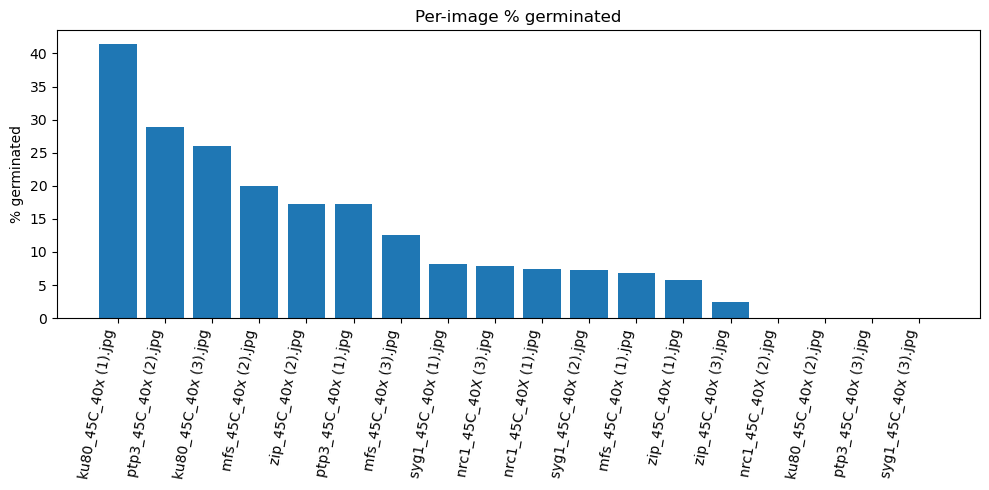

In [4]:
# === Batch Fungal Germination Counter (40×, hybrid + robust v2) ==============
# Germinated if germ tube length ≥ max(1.3× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/45C/09_18_2025_45C_low_contrast"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Size gates & seeding tuned for consistency
MIN_AREA = 220           # px^2 (raise to 240 if tiny specks persist)
MAX_AREA = 1800          # px^2
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96

# Germination rule
UM_PER_PX = 0.22         # <-- set from your scale bar
MIN_TUBE_MULTIPLE = 1.3  # relative minimum (was 1.5)
ABS_TUBE_MIN_UM = 5.0    # absolute minimum (µm)
BORDERLINE_UM = 1.0

# Skeleton continuity (NEW: more forgiving)
SKELETON_DILATE = 2      # was 1

# Feature/contrast gating
TOPHAT_RADIUS = 15       # px (~3–4 µm @ 40×)
FEAT_MIN = 0.035         # min mean feature intensity inside a component (0–1)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & mild enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = filters.gaussian(gray, sigma=GAUSSIAN_SIGMA)

    # ---- background suppression via top-hat (feature image) ----
    disk = morphology.disk(TOPHAT_RADIUS)
    wh = morphology.white_tophat(g, footprint=disk)
    bh = morphology.white_tophat(1.0 - g, footprint=disk)
    feat = np.maximum(wh, bh)
    feat = feat / (feat.max() + 1e-8)

    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)
        bw = morphology.binary_closing(bw, morphology.disk(3))  # bridge tiny gaps
        return bw

    def safe_thresh(fn, arr):
        try:
            return fn(arr)
        except ValueError:
            return 0.0

    # --- candidate masks on FEATURE image ---
    th_of = safe_thresh(filters.threshold_otsu,     feat)
    th_yf = safe_thresh(filters.threshold_yen,      feat)
    th_tf = safe_thresh(filters.threshold_triangle, feat)
    bw_feat_otsu = cleanup(feat > th_of)
    bw_feat_yen  = cleanup(feat > th_yf)
    bw_feat_tri  = cleanup(feat > th_tf)

    # --- candidate masks on ORIGINAL (for clean fields) ---
    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    SAUVOLA_WINDOW, SAUVOLA_K = 41, 0.12
    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw_sauv_n = cleanup(blur > thN)
    bw_sauv_i = cleanup(blur_inv > thI)

    to = safe_thresh(filters.threshold_otsu,     blur_inv)
    ty = safe_thresh(filters.threshold_yen,      blur_inv)
    tt = safe_thresh(filters.threshold_triangle, blur_inv)
    bw_otsu_i = cleanup(blur_inv > to)
    bw_yen_i  = cleanup(blur_inv > ty)
    bw_tri_i  = cleanup(blur_inv > tt)

    # --- scoring: plausible count, low confetti, not over-merged,
    #              prefer masks with strong feature signal, avoid ultra-sparse ---
    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        if not areas:
            return (-1e9,)  # worst score
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)

        # tiny specks fraction (confetti)
        small = sum(a for a in areas if a < MIN_AREA)
        confetti = small / max(1, int(mask.sum()))

        # over-merge indicator
        frac_big = max(areas) / max(1, int(mask.sum()))

        # target range for n_ok (tuned for 40× fields)
        lo, hi = 30, 200
        band_pen = 0.0
        if n_ok < lo:
            band_pen = - (lo - n_ok) * 0.75
        elif n_ok > hi:
            band_pen = - (n_ok - hi) * 0.10

        # NEW: reward masks whose pixels have strong feature response
        feat_mean = float(feat[mask].mean()) if mask.any() else 0.0
        feat_bonus = 20.0 * feat_mean

        # NEW: penalize ultra-sparse masks (low-contrast globals)
        fill = mask.mean()  # fraction of image marked
        sparse_pen = 0.0 if fill >= 0.005 else -50.0

        return (n_ok + band_pen) - 150.0*confetti - 5.0*frac_big + feat_bonus + sparse_pen

    candidates = [
        ("feat_otsu", bw_feat_otsu),
        ("feat_yen",  bw_feat_yen),
        ("feat_tri",  bw_feat_tri),
        ("sauv_normal", bw_sauv_n),
        ("sauv_invert", bw_sauv_i),
        ("otsu_invert", bw_otsu_i),
        ("yen_invert",  bw_yen_i),
        ("tri_invert",  bw_tri_i),
    ]
    scored = [(nm, m, score_mask(m)) for nm, m in candidates]
    name, bw, _ = max(scored, key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))
    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: stronger peak suppression if one giant blob
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ max(1.3×D, 5 µm)) with contrast gate ----
    props = measure.regionprops(labels, intensity_image=feat)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        mean_feat = float(p.mean_intensity) if hasattr(p, "mean_intensity") else 0.0
        if mean_feat < FEAT_MIN:
            continue  # drop flat background blobs

        # drop only obvious wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        # measure skeleton on a dilated region (NEW: SKELETON_DILATE=2)
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(SKELETON_DILATE))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_px = p.equivalent_diameter
        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "mean_feat": mean_feat,
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","mean_feat","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity","is_germinated",
            "margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # Optional quick plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()


### 09_18_2025_50C (low contrast)

Found 19 image(s). Example: ['/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/zip_50C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/zip_50C_40x (2).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/zip_50C_40x (1).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/syg1_50C_40x (3).jpg', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/syg1_50C_40x (2).jpg']


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (1)_mask_feat_otsu.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ku80_50C_40x (1).jpg -> N=15  germinated=1  (6.7%)  mask=feat_otsu  seed_min_dist=15  overlay=ku80_50C_40x (1)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (2)_mask_feat_tri.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (2)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ku80_50C_40x (2).jpg -> N=15  germinated=0  (0.0%)  mask=feat_tri  seed_min_dist=15  overlay=ku80_50C_40x (2)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (3)_mask_feat_yen.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (3)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ku80_50C_40x (3).jpg -> N=14  germinated=0  (0.0%)  mask=feat_yen  seed_min_dist=17  overlay=ku80_50C_40x (3)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (4)_mask_feat_tri.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/ku80_50C_40x (4)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


ku80_50C_40x (4).jpg -> N=13  germinated=0  (0.0%)  mask=feat_tri  seed_min_dist=18  overlay=ku80_50C_40x (4)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/mfs_50C_40x (1)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/mfs_50C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


mfs_50C_40x (1).jpg -> N=24  germinated=7  (29.2%)  mask=otsu_invert  seed_min_dist=16  overlay=mfs_50C_40x (1)_overlay.png
mfs_50C_40x (2).jpg -> N=24  germinated=0  (0.0%)  mask=feat_tri  seed_min_dist=15  overlay=mfs_50C_40x (2)_overlay.png
mfs_50C_40x (3).jpg -> N=279  germinated=95  (34.1%)  mask=otsu_invert  seed_min_dist=15  overlay=mfs_50C_40x (3)_overlay.png
nrc1_50C_40x (1).jpg -> N=8  germinated=0  (0.0%)  mask=feat_otsu  seed_min_dist=16  overlay=nrc1_50C_40x (1)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/nrc1_50C_40x (2)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


nrc1_50C_40x (2).jpg -> N=48  germinated=14  (29.2%)  mask=tri_invert  seed_min_dist=15  overlay=nrc1_50C_40x (2)_overlay.png
nrc1_50C_40x (3).jpg -> N=267  germinated=103  (38.6%)  mask=otsu_invert  seed_min_dist=15  overlay=nrc1_50C_40x (3)_overlay.png
ptp3_50C_40x (1).jpg -> N=48  germinated=12  (25.0%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_50C_40x (1)_overlay.png
ptp3_50C_40x (2).jpg -> N=288  germinated=121  (42.0%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_50C_40x (2)_overlay.png
ptp3_50C_40x (3).jpg -> N=287  germinated=100  (34.8%)  mask=otsu_invert  seed_min_dist=15  overlay=ptp3_50C_40x (3)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/syg1_50C_40x (1)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))


syg1_50C_40x (1).jpg -> N=34  germinated=20  (58.8%)  mask=otsu_invert  seed_min_dist=15  overlay=syg1_50C_40x (1)_overlay.png
syg1_50C_40x (2).jpg -> N=126  germinated=59  (46.8%)  mask=otsu_invert  seed_min_dist=15  overlay=syg1_50C_40x (2)_overlay.png
syg1_50C_40x (3).jpg -> N=126  germinated=52  (41.3%)  mask=otsu_invert  seed_min_dist=15  overlay=syg1_50C_40x (3)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/zip_50C_40x (1)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


zip_50C_40x (1).jpg -> N=20  germinated=1  (5.0%)  mask=feat_otsu  seed_min_dist=16  overlay=zip_50C_40x (1)_overlay.png
zip_50C_40x (2).jpg -> N=149  germinated=54  (36.2%)  mask=otsu_invert  seed_min_dist=15  overlay=zip_50C_40x (2)_overlay.png


/tmp/ipykernel_2664847/1747223411.py:153: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/zip_50C_40x (3)_mask_otsu_invert.png is a low contrast image
  io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
/tmp/ipykernel_2664847/1747223411.py:271: UserWarning: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/zip_50C_40x (3)_overlay.png is a low contrast image
  io.imsave(out_png, overlay)


zip_50C_40x (3).jpg -> N=15  germinated=5  (33.3%)  mask=otsu_invert  seed_min_dist=15  overlay=zip_50C_40x (3)_overlay.png
Saved per-object measurements: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/germination_measurements_all.csv
Saved borderline objects: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/germination_measurements_all_borderline.csv
Saved per-image summary: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast/germination_measurements_all_perimage_summary.csv


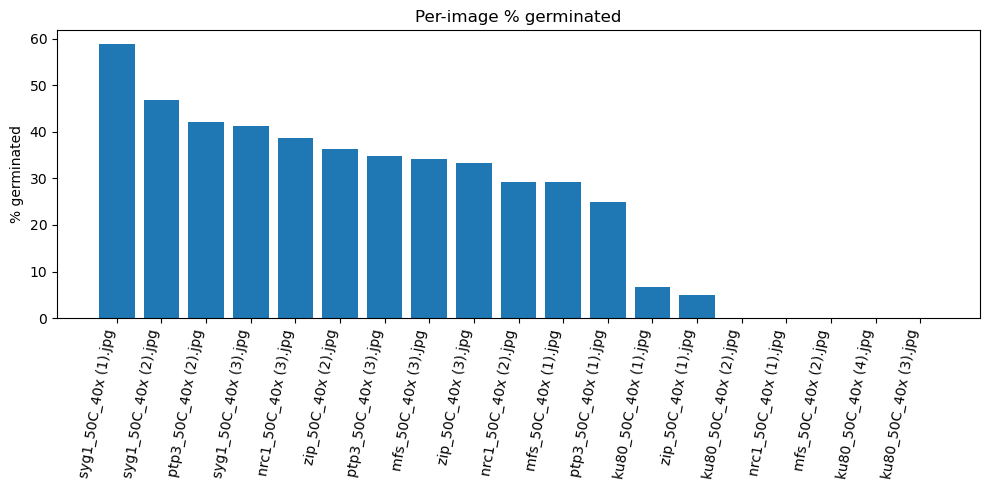

In [5]:
# === Batch Fungal Germination Counter (40×, hybrid + robust v2) ==============
# Germinated if germ tube length ≥ max(1.3× spore diameter, 5 µm)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/plate_germination_assays_revised/09_18_2025_run/50C/09_18_2025_50C_low_contrast"
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Size gates & seeding tuned for consistency
MIN_AREA = 220           # px^2 (raise to 240 if tiny specks persist)
MAX_AREA = 1800          # px^2
GAUSSIAN_SIGMA = 1.0
HOLE_AREA = 96

# Germination rule
UM_PER_PX = 0.22         # <-- set from your scale bar
MIN_TUBE_MULTIPLE = 1.3  # relative minimum (was 1.5)
ABS_TUBE_MIN_UM = 5.0    # absolute minimum (µm)
BORDERLINE_UM = 1.0

# Skeleton continuity (NEW: more forgiving)
SKELETON_DILATE = 2      # was 1

# Feature/contrast gating
TOPHAT_RADIUS = 15       # px (~3–4 µm @ 40×)
FEAT_MIN = 0.035         # min mean feature intensity inside a component (0–1)
# -----------------------------------------------------------------------------

def parse_meta(filename, meta_regex=None):
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    # ---- read & mild enhance ----
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)
    g = filters.gaussian(gray, sigma=GAUSSIAN_SIGMA)

    # ---- background suppression via top-hat (feature image) ----
    disk = morphology.disk(TOPHAT_RADIUS)
    wh = morphology.white_tophat(g, footprint=disk)
    bh = morphology.white_tophat(1.0 - g, footprint=disk)
    feat = np.maximum(wh, bh)
    feat = feat / (feat.max() + 1e-8)

    def cleanup(bw):
        bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
        bw = morphology.remove_small_objects(bw, MIN_AREA // 2)
        bw = ndi.binary_fill_holes(bw)
        bw = morphology.binary_closing(bw, morphology.disk(3))  # bridge tiny gaps
        return bw

    def safe_thresh(fn, arr):
        try:
            return fn(arr)
        except ValueError:
            return 0.0

    # --- candidate masks on FEATURE image ---
    th_of = safe_thresh(filters.threshold_otsu,     feat)
    th_yf = safe_thresh(filters.threshold_yen,      feat)
    th_tf = safe_thresh(filters.threshold_triangle, feat)
    bw_feat_otsu = cleanup(feat > th_of)
    bw_feat_yen  = cleanup(feat > th_yf)
    bw_feat_tri  = cleanup(feat > th_tf)

    # --- candidate masks on ORIGINAL (for clean fields) ---
    blur = filters.gaussian(g, sigma=GAUSSIAN_SIGMA)
    blur_inv = 1.0 - blur

    SAUVOLA_WINDOW, SAUVOLA_K = 41, 0.12
    thN = filters.threshold_sauvola(blur,     window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    thI = filters.threshold_sauvola(blur_inv, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw_sauv_n = cleanup(blur > thN)
    bw_sauv_i = cleanup(blur_inv > thI)

    to = safe_thresh(filters.threshold_otsu,     blur_inv)
    ty = safe_thresh(filters.threshold_yen,      blur_inv)
    tt = safe_thresh(filters.threshold_triangle, blur_inv)
    bw_otsu_i = cleanup(blur_inv > to)
    bw_yen_i  = cleanup(blur_inv > ty)
    bw_tri_i  = cleanup(blur_inv > tt)

    # --- scoring: plausible count, low confetti, not over-merged,
    #              prefer masks with strong feature signal, avoid ultra-sparse ---
    def score_mask(mask):
        lab = measure.label(mask)
        areas = [r.area for r in measure.regionprops(lab)]
        if not areas:
            return (-1e9,)  # worst score
        ok = [a for a in areas if MIN_AREA <= a <= MAX_AREA]
        n_ok = len(ok)

        # tiny specks fraction (confetti)
        small = sum(a for a in areas if a < MIN_AREA)
        confetti = small / max(1, int(mask.sum()))

        # over-merge indicator
        frac_big = max(areas) / max(1, int(mask.sum()))

        # target range for n_ok (tuned for 40× fields)
        lo, hi = 30, 200
        band_pen = 0.0
        if n_ok < lo:
            band_pen = - (lo - n_ok) * 0.75
        elif n_ok > hi:
            band_pen = - (n_ok - hi) * 0.10

        # NEW: reward masks whose pixels have strong feature response
        feat_mean = float(feat[mask].mean()) if mask.any() else 0.0
        feat_bonus = 20.0 * feat_mean

        # NEW: penalize ultra-sparse masks (low-contrast globals)
        fill = mask.mean()  # fraction of image marked
        sparse_pen = 0.0 if fill >= 0.005 else -50.0

        return (n_ok + band_pen) - 150.0*confetti - 5.0*frac_big + feat_bonus + sparse_pen

    candidates = [
        ("feat_otsu", bw_feat_otsu),
        ("feat_yen",  bw_feat_yen),
        ("feat_tri",  bw_feat_tri),
        ("sauv_normal", bw_sauv_n),
        ("sauv_invert", bw_sauv_i),
        ("otsu_invert", bw_otsu_i),
        ("yen_invert",  bw_yen_i),
        ("tri_invert",  bw_tri_i),
    ]
    scored = [(nm, m, score_mask(m)) for nm, m in candidates]
    name, bw, _ = max(scored, key=lambda x: x[2])

    # Save chosen mask for QC
    try:
        io.imsave(os.path.splitext(path)[0] + f"_mask_{name}.png", util.img_as_ubyte(bw))
    except Exception:
        pass

    # ---- size-aware watershed seeding (looser to avoid over-splits) ----
    dist = ndi.distance_transform_edt(bw)
    lab0 = measure.label(bw)
    eq_diams = [r.equivalent_diameter for r in measure.regionprops(lab0)
                if MIN_AREA <= r.area <= MAX_AREA]
    med_eq_px = np.median(eq_diams) if len(eq_diams) else 20.0

    min_dist = int(np.clip(0.45 * med_eq_px, 15, 22))
    coords = feature.peak_local_max(dist, min_distance=min_dist, labels=bw, exclude_border=False)
    seeds = np.zeros_like(dist, dtype=bool)
    if coords.size:
        seeds[tuple(coords.T)] = True
    markers = measure.label(seeds)
    labels = segmentation.watershed(-dist, markers, mask=bw)

    # Fallback: stronger peak suppression if one giant blob
    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) <= 5 or (areas and max(areas) > 0.5 * bw.sum()):
        h = 0.55 * np.median(dist[dist > 0]) if np.any(dist > 0) else 1.0
        hmax = morphology.h_maxima(dist, h=h)
        labels2 = segmentation.watershed(-dist, measure.label(hmax), mask=bw)

        def quality(lab):
            a = [r.area for r in measure.regionprops(lab)]
            ok = [x for x in a if MIN_AREA <= x <= MAX_AREA]
            frac_big = (max(a) / max(1, int(bw.sum()))) if a else 1.0
            return len(ok), -frac_big
        if quality(labels2) > quality(labels):
            labels = labels2

    # ---- measure + classify (tube ≥ max(1.3×D, 5 µm)) with contrast gate ----
    props = measure.regionprops(labels, intensity_image=feat)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        mean_feat = float(p.mean_intensity) if hasattr(p, "mean_intensity") else 0.0
        if mean_feat < FEAT_MIN:
            continue  # drop flat background blobs

        # drop only obvious wisps
        perim = max(p.perimeter, 1.0)
        solidity = float(p.solidity)
        circularity = float(4*np.pi*p.area/(perim**2))
        if (solidity < 0.45 and circularity < 0.25):
            continue

        # measure skeleton on a dilated region (NEW: SKELETON_DILATE=2)
        region = (labels == p.label)
        region = morphology.binary_dilation(region, morphology.disk(SKELETON_DILATE))
        skel = morphology.skeletonize(region)
        sklen_px = int(np.count_nonzero(skel))

        equiv_px = p.equivalent_diameter
        equiv_um = float(equiv_px * UM_PER_PX)
        sklen_um = float(sklen_px * UM_PER_PX)
        tube_um  = max(0.0, sklen_um - equiv_um)

        cutoff_um = max(MIN_TUBE_MULTIPLE * equiv_um, ABS_TUBE_MIN_UM)
        is_germ = int(tube_um >= cutoff_um)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "mean_feat": mean_feat,
            "equiv_diameter_um": float(equiv_um),
            "skeleton_len_um": float(sklen_um),
            "germ_tube_um": float(tube_um),
            "cutoff_um": float(cutoff_um),
            "solidity": float(solidity),
            "circularity": float(circularity),
            "is_germinated": is_germ,
            "margin_um": tube_um - cutoff_um,
            "mask_method": name,
            "seed_min_distance_px": int(min_dist)
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    if not rows:
        return pd.DataFrame(columns=[
            "file","label","area_px","mean_feat","equiv_diameter_um","skeleton_len_um",
            "germ_tube_um","cutoff_um","solidity","circularity","is_germinated",
            "margin_um","mask_method","seed_min_distance_px"
        ]), overlay

    return pd.DataFrame(rows), overlay

# ----------------------- RUN BATCH -------------------------------------------
VALID_EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}
VALID_EXTS |= {e.upper() for e in VALID_EXTS}
paths = [str(p) for p in Path(image_folder).glob("*") if p.suffix in VALID_EXTS]

print(f"Found {len(paths)} image(s). Example:", paths[:5])
assert len(paths) > 0, f"No images found at: {image_folder}"

all_rows = []
per_image_rows = []

for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if "strain" in meta and meta["strain"] is not None: df["strain"] = meta["strain"]
    if "temp" in meta and meta["temp"] is not None: df["temp"] = meta["temp"]
    if "replicate" in meta and meta["replicate"] is not None: df["replicate"] = meta["replicate"]
    all_rows.append(df)

    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    total = int(len(df))
    germinated = int(df["is_germinated"].sum()) if "is_germinated" in df else 0
    percent = (100.0 * germinated / max(1, total)) if total else 0.0
    mask_method = df["mask_method"].iloc[0] if "mask_method" in df and len(df) else "NA"
    seed_space  = df["seed_min_distance_px"].iloc[0] if "seed_min_distance_px" in df and len(df) else "NA"
    strain      = df["strain"].iloc[0] if "strain" in df and len(df) else None
    temp        = df["temp"].iloc[0] if "temp" in df and len(df) else None

    per_image_rows.append({
        "file": os.path.basename(p),
        "strain": strain, "temp": temp,
        "total": total, "germinated": germinated, "percent_germinated": percent,
        "mask_method": mask_method, "seed_min_distance_px": seed_space
    })

    print(f"{os.path.basename(p)} -> N={total}  germinated={germinated}  ({percent:.1f}%)  "
          f"mask={mask_method}  seed_min_dist={seed_space}  overlay={os.path.basename(out_png)}")

# per-object table
big = pd.concat(all_rows, ignore_index=True) if len(all_rows) else pd.DataFrame()
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Save borderline objects for QC
if "margin_um" in big:
    border = big["margin_um"].abs() <= BORDERLINE_UM
    big.loc[border].to_csv(f"{output_prefix}_borderline.csv", index=False)
    print("Saved borderline objects:", f"{output_prefix}_borderline.csv")

# per-image concise log
per_image = pd.DataFrame(per_image_rows)
per_image.to_csv(f"{output_prefix}_perimage_summary.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perimage_summary.csv")

# ----------------------- GROUPED SUMMARIES -----------------------------------
if not per_image.empty:
    per_image_with_meta = per_image.copy()
    has_meta = per_image_with_meta.dropna(subset=["strain","temp"])
    if not has_meta.empty:
        summary = (
            has_meta
            .groupby(["strain","temp"])["percent_germinated"]
            .agg(["mean","std","count"])
            .reset_index()
        )
        summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
        summary["ci95"] = 1.96 * summary["sem"]
        summary = summary.sort_values(["strain","temp"])
        summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)

        # Optional quick plots
        plt.figure(figsize=(10, 5))
        order = per_image.sort_values("percent_germinated", ascending=False)
        plt.bar(order["file"], order["percent_germinated"])
        plt.xticks(rotation=80, ha="right")
        plt.ylabel("% germinated")
        plt.title("Per-image % germinated")
        plt.tight_layout()
        plt.show()
